# **Car detection system**

This detection system detects cars on image of arbitrary size.
It loads already trained models and uses them.

# Loading datasets

In [1]:
import os
import re
import gc
import time
import copy
import json
import math
import copy
import psutil
import builtins
import functools as ft
from PIL import Image
from PIL import ImageDraw
import random
import pathlib
import zipfile
from google.colab import drive
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

In [2]:
drive.mount('/content/drive')
CARS_DS_ZIPFILE_PATH = '/content/drive/My Drive/cars_ds.zip'
GDS_FOLDER = pathlib.Path('/content/drive/My Drive/google_cars_ds')
GDS_IMAGE = GDS_FOLDER / 'images' / '1.png'
GDS_LABEL = GDS_FOLDER / 'labels' / '1.json'

zfile = zipfile.ZipFile(CARS_DS_ZIPFILE_PATH, 'r')

def get_sample_paths(index):
    img_path = IMG_FOLDER / os.listdir(IMG_FOLDER)[index]
    label_path = LABEL_FOLDER / (img_path.stem + '.json')
    return img_path, label_path

CARS_DS_DIR = pathlib.Path('/content/dataset')
if not CARS_DS_DIR.exists():
    os.mkdir(CARS_DS_DIR)
    zfile.extractall(CARS_DS_DIR)

IMG_FOLDER = CARS_DS_DIR / 'cars_ds' / 'images'
LABELS_PATHS = CARS_DS_DIR / 'cars_ds' / 'labels.json'
with open(LABELS_PATHS) as file:
    labels = json.load(file)['data']

BBOXES = 'boundingboxes'
FILENAME = 'filename'

def get_centers(boxes):
    return list(map(lambda b: ((b[2]+b[0])/2, (b[3]+b[1])/2), boxes))

dataset = []
for label in labels:
    path = str(IMG_FOLDER/label[FILENAME])
    centers = get_centers(label[BBOXES])
    dataset.append((path, centers))

def explore_dataset(dataset):
    all_marks_num = 0
    max_marks_num = 0
    for _, marks in dataset:
        all_marks_num += len(marks)
        max_marks_num = max(max_marks_num, len(marks))
    print('Number of all marked images in dataset: {}'.format(len(dataset)))
    print('Number of bboxes for all images: {}'.format(all_marks_num))
    print('Maximum number of boxes: {}'.format(max_marks_num))
    print('Average number of boxes: {:.2f}'.format(all_marks_num/len(dataset)))
explore_dataset(dataset)

print('\nDataset content:')
print(*dataset[:3], sep='\n')
print('...')

Mounted at /content/drive
Number of all marked images in dataset: 3748
Number of bboxes for all images: 10555
Maximum number of boxes: 72
Average number of boxes: 2.82

Dataset content:
('/content/dataset/cars_ds/images/000000000.jpg', [(64.025, 157.87), (15.875, 211.24), (52.230000000000004, 46.845)])
('/content/dataset/cars_ds/images/000000001.jpg', [(64.025, 45.870000000000005), (15.875, 99.24000000000001)])
('/content/dataset/cars_ds/images/000000002.jpg', [(209.83499999999998, 216.685), (219.01999999999998, 126.085)])
...


# Detection pipeline

In [3]:
def get_img(path):
    img = Image.open(path)
    img.load()
    return img

def plot_img(img, title=''):
    plt.xticks([])
    plt.yticks([])
    if title:
        plt.title(title)
    plt.imshow(img, cmap=plt.cm.binary)

def draw_center_square(img, center, color='red', radius=1, width=1):
    center = (int(round(center[0])), int(round(center[1])))
    c, w, r = center, width, radius
    draw = ImageDraw.Draw(img)
    draw.rectangle([c[0]-r, c[1]-r, c[0]+r-1, c[1]+r-1], outline=color, width=w)

def draw_centers(img, centers, color='red', radius=5, width=1):
    for c in centers:
        draw_center_square(img, c, color=color, radius=radius, width=width)

def plot_samples(samples, col_num=10):
    num = len(samples)
    FW = 1.4
    row_num = (num-1)//col_num+1
    plt.figure(figsize=(FW*col_num, 1.1*FW*row_num))
    for k, (f_img, prob)  in enumerate(samples):
        plt.subplot(row_num, col_num, k+1)
        prob_str = '0' if prob < 0.001 else '{:.2f}'.format(prob)
        t = 'k{} p{}'.format(k, prob_str)
        plot_img(f_img, t)

def plot_batch(x_batch, y_batch):
    samples = []
    for k, x in enumerate(x_batch):
        prob = y_batch[k][0]
        samples.append([x, prob])
    plot_samples(samples, col_num=11)

def dist(pt_1, pt_2):
    return math.sqrt((pt_2[0]-pt_1[0])**2 + (pt_2[1]-pt_1[1])**2)

def dist2(pt_1, pt_2):
    return (pt_2[0]-pt_1[0])**2 + (pt_2[1]-pt_1[1])**2

def find_closest(pt, points):
    sq_dists = list(map(lambda x: dist2(pt, x), points))
    min_idx = np.argmin(sq_dists)
    return (min_idx, points[min_idx])

def find_min_dist(pt, points):
    _, cl_pt = find_closest(pt, points)
    return dist(cl_pt, pt)

In [4]:
# Attention model - model, trained to classify images with cars.
# It's ised for computation of attention map.
# Detection model - model, trained to classify images with cars in center.
# It's ised for detect cars.

# Fundamental constants
FI_W = 24 # width (and height) of image, that uses detector model
STRIDE = 3  # Stride for detection sliding window algorithm. May be 
NOM_PADDING = 4  # top and left padding fro attention map
ATTENTION_PROB_THRESHOLD = 0.1

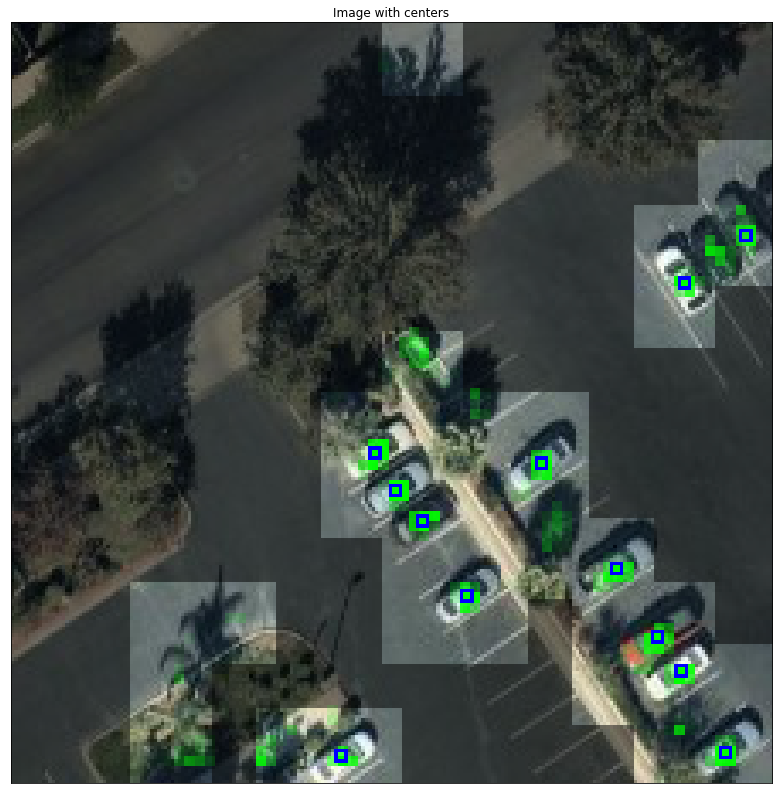

dark part of image - area, that not deserves attention
green squares - high probability of car center
blue squares - predicted center
res square - ground truth center
Results: IOU = 0.92, variance = 1.1(pixels)


In [14]:
def get_map_params(img_size):
    w, h = img_size
    mw = int(round((w - 2 * NOM_PADDING)/STRIDE))
    mh= int(round((h - 2 * NOM_PADDING)/STRIDE))
    left_padding = int(round((w - mw * STRIDE) / 2))
    top_padding = int(round((h - mh * STRIDE) / 2))
    return mh, mw, top_padding, left_padding

def get_coords_of_map_elt(map_params, i, j):
    _, _, top_padding, left_padding = map_params
    y = top_padding + i * STRIDE
    x = left_padding + j * STRIDE
    return x, y

def compute_att_mask_rects(img_size, nom_stride):
    w, h = img_size
    l_padd = math.floor(nom_stride/2)
    t_padd = l_padd
    x_nom_num = math.ceil((w - nom_stride) / nom_stride)
    x_stride = (w - nom_stride) / x_nom_num
    y_nom_num = math.ceil((h - nom_stride) / nom_stride)
    y_stride = (h - nom_stride) / y_nom_num
    rects = []
    for i in range(y_nom_num + 1):
        for j in range(x_nom_num + 1):
            x = l_padd + int(round(j * x_stride))
            y = t_padd + int(round(i * y_stride))
            rect = [x - math.floor(FI_W/2), y - math.floor(FI_W/2),
                    x + math.ceil(FI_W/2), y + math.ceil(FI_W/2)]
            rects.append(rect)
    return rects

def compute_attention_mask(o_img, attention_model):
    NOM_STRIDE = 20
    att_mask = np.zeros((o_img.height, o_img.width), dtype=np.float32)
    rects = compute_att_mask_rects(o_img.size, NOM_STRIDE)
    batch_len = len(rects)

    x_batch = np.ndarray((batch_len, FI_W,FI_W,3), dtype=np.uint8)
    for k, rect in enumerate(rects):
        x_batch[k] = np.array(o_img.crop(rect), dtype=np.uint8)
    y_preds = attention_model.predict(x_batch)
    for k, y_pred in enumerate(y_preds):
        h, w = att_mask.shape
        xmin, ymin, xmax, ymax = rects[k]
        xmin, ymin = max(0, xmin), max(0, ymin)
        xmax, ymax = min(w, xmax), min(h, ymax)
        fill_arr = np.ndarray((ymax-ymin, xmax-xmin), dtype=np.float32)
        fill_arr.fill(y_pred[0])
        am_slice = att_mask[ymin:ymax, xmin:xmax]
        am_slice[:,:] = np.maximum(am_slice, fill_arr)
    return att_mask

def draw_attention_mask_above(o_img, attention_mask):
    A_MIN = 128
    am_booled = (lambda x: x > ATTENTION_PROB_THRESHOLD)(attention_mask)
    am_RGBA_arr = np.zeros((*am_booled.shape, 4), dtype=np.uint8)
    am_RGBA_arr[:,:,3] = (am_booled * (-1) + 1) * A_MIN
    am_RGBA = Image.fromarray(am_RGBA_arr, mode='RGBA')
    o_img_RGBA = o_img.convert('RGBA')
    o_img_RGBA.alpha_composite(am_RGBA)
    return o_img_RGBA

def draw_detection_map_above(o_img, detection_map):
    S = STRIDE
    BASE_COLOR = (0,255,0)
    map_img = Image.new('RGBA', o_img.size, color=(0,0,0,0))
    map_params = get_map_params(map_img.size)
    # mh, mw, t_pad, l_pad = map_params
    draw = ImageDraw.Draw(map_img)
    for i, line in enumerate(detection_map):
        for j, elt in enumerate(line):
            if elt < 0.001:
                continue
            c = get_coords_of_map_elt(map_params, i, j)
            rect = [c[0]-math.floor(S/2), c[1]-math.floor(S/2),
                    c[0]+math.floor(S/2), c[1]+math.floor(S/2)]
            COLOR = (*BASE_COLOR, int(round(elt*255)))
            draw.rectangle(rect, fill=COLOR)
    o_img = o_img.convert('RGBA')
    o_img.alpha_composite(map_img)
    return o_img

def compute_detection_map(o_img, attention_mask, model):
    map_params = get_map_params(o_img.size)
    mh, mw, top_padding, left_padding = map_params
    att_map = np.zeros((mh,mw), dtype=np.bool)
    for i, line in enumerate(att_map):
        for j, elt in enumerate(line):
            c = get_coords_of_map_elt(map_params, i, j)
            if attention_mask[c[1],c[0]] > ATTENTION_PROB_THRESHOLD:
                att_map[i,j] = True

    batch_len = ft.reduce(lambda x, y: x + int(y), att_map.flat, 0)
    detection_map = np.zeros(att_map.shape, dtype=np.float32)
    if batch_len == 0:
        return detection_map
    x_batch = np.zeros((batch_len, FI_W, FI_W, 3), dtype=np.int32)    
    counter = 0
    for i, line in enumerate(att_map):
        for j, elt in enumerate(line):
            if not elt:
                continue
            c = get_coords_of_map_elt(map_params, i, j)
            rect = [c[0]-math.floor(FI_W/2), c[1]-math.floor(FI_W/2),
                    c[0]+math.ceil(FI_W/2), c[1]+math.ceil(FI_W/2)]
            fragm = o_img.crop(rect)
            x_batch[counter] = fragm
            counter += 1
    y_pred = model.predict(x_batch)
    counter = 0
    for i, line in enumerate(att_map):
        for j, elt in enumerate(line):
            if not elt:
              continue
            detection_map[i,j] = y_pred[counter][0]
            counter += 1
    return detection_map

def compute_car_centers(detection_map, stride):
    d_centers = []
    assert stride == 3
    MAX_PROB_THRESHOLD = 0.5
    MASS_THRESHOLD = 3.0
    R = 1
    det = copy.deepcopy(detection_map)
    h, w = det.shape
    while True:
        max_i, max_j = np.unravel_index(np.argmax(det), det.shape)
        if det[max_i, max_j] < MAX_PROB_THRESHOLD:
            break
        mass = 0.
        c_mass = [0.,0.]
        for i in range(max(0, max_i-R), min(max_i+R+1, h)):
            for j in range(max(0, max_j-R), min(max_j+R+1, w)):
                c_mass[0] += det[i,j] * j
                c_mass[1] += det[i,j] * i
                mass += det[i,j]
                det[i,j] = 0
        c_mass[0], c_mass[1] = c_mass[0] / mass, c_mass[1] / mass
        if mass > MASS_THRESHOLD:
            d_centers.append(tuple(c_mass))
    return d_centers

def convert_from_map_coords(img_size, points):
    map_params = get_map_params(img_size)
    _, _, top_padding, left_padding = map_params
    res = []
    for pt in points:
        c = (left_padding + STRIDE * pt[0], top_padding + STRIDE * pt[1])
        res.append(c)
    return res

def detect_cars_on_image(o_img, det_model, att_model):
    attention_mask = compute_attention_mask(o_img, att_model)
    at_img = draw_attention_mask_above(o_img, attention_mask)
    detection_map = compute_detection_map(o_img, attention_mask, det_model)
    det_img = draw_detection_map_above(at_img, detection_map)
    d_centers = compute_car_centers(detection_map, STRIDE)
    d_centers = convert_from_map_coords(o_img.size, d_centers)
    return d_centers, det_img

DET_MODELS = pathlib.Path('/content/drive/My Drive/cars_bclassif_2_models')
DET_MODEL_PATH = DET_MODELS / 'm1' / 'model_9.hdf5'
ATT_MODEL_PATH = DET_MODELS / 'att1' / 'model_3.hdf5'
LOC_MODELS = pathlib.Path('/content/drive/My Drive/cars_location_3_models')
LOC_MODEL_PATH = LOC_MODELS / 'm10' / 'model_3.hdf5'

def evaluate_centers(o_centers, d_centers):
    corrects = 0
    dists = []
    d_centers_copy = copy.deepcopy(d_centers)
    DIST_THRESHOLD = 4
    for o_c in o_centers:
        if not d_centers_copy:
            break
        d_idx, d_c = find_closest(o_c, d_centers_copy)
        min_dist = dist(o_c, d_c)
        if min_dist < DIST_THRESHOLD:
            corrects += 1
            dists.append(min_dist)
            del d_centers_copy[d_idx]
    iou = corrects / (len(o_centers) + len(d_centers) - corrects)
    variance = 4
    if dists:
        variance = ft.reduce(lambda x,y: x+y, dists) / len(dists) 
    return iou, variance 

def detect_cars_check():
    oi_index = 5
    path, o_centers = dataset[oi_index][0], dataset[oi_index][1]
    o_img = get_img(path)
    det_model = tf.keras.models.load_model(str(DET_MODEL_PATH))
    att_model = tf.keras.models.load_model(str(ATT_MODEL_PATH))
    d_centers, debug_img = detect_cars_on_image(o_img, det_model, att_model)
    plt.figure(figsize=(14,14))
    # draw_centers(debug_img, o_centers, color='red', radius=1)
    draw_centers(debug_img, d_centers, color='blue', radius=2)
    plot_img(debug_img, 'Image with centers')
    plt.show()
    print('dark part of image - area, that not deserves attention')
    print('green squares - high probability of car center')
    print('blue squares - predicted center')
    print('res square - ground truth center')
    iou, variance = evaluate_centers(o_centers, d_centers)
    print('Results: IOU = {:.2f}, variance = {:.1f}(pixels)'.format(iou,
                                                                    variance))

detect_cars_check()

# Cars detection on google maps screenshot


In [13]:
GDS_FOLDER = pathlib.Path('/content/drive/My Drive/google_cars_ds')
GDS_IMAGE = GDS_FOLDER / 'images' / '1.png'
GDS_LABEL = GDS_FOLDER / 'labels' / '1.json'

def get_centers_from_label_file(path):
    with open(path) as f:
       label = json.load(f)
    return label['car_centers']

def scale_centers(points, scale):
    scaled_points = []
    for pt in points:
        sp = (int(round(pt[0]*scale)), int(round(pt[1]*scale)))
        scaled_points.append(sp)
    return scaled_points

def scale_g_sample(gimg_path, glabel_path, scale):
    gimg = get_img(gimg_path)
    gimg = gimg.convert('RGB')
    size = (int(round(gimg.width*scale)), int(round(gimg.height*scale)))
    scaled_img = gimg.resize(size, resample=2, reducing_gap=3.0)
    gcenters = get_centers_from_label_file(glabel_path)
    scaled_centers = scale_centers(gcenters, scale)
    return scaled_img, scaled_centers

def detect_cars_on_google_maps_screenshot():
    CHOSEN_SCALE = 0.6
    img, centers = scale_g_sample(GDS_IMAGE, GDS_LABEL, CHOSEN_SCALE)

    det_model = tf.keras.models.load_model(str(DET_MODEL_PATH))
    att_model = tf.keras.models.load_model(str(ATT_MODEL_PATH))
    d_centers, debug_img = detect_cars_on_image(img, det_model, att_model)
    plt.figure(figsize=(28,20))
    draw_centers(debug_img, centers, color='red', radius=1)
    draw_centers(debug_img, d_centers, color='blue', radius=2)
    plot_img(debug_img, 'Image with centers')
    plt.show()
    iou, variance = evaluate_centers(centers, d_centers)
    print('Results: IOU = {:.2f}, variance = {:.1f}(pixels)'.format(iou,
                                                                    variance))

detect_cars_on_google_maps_screenshot()

Output hidden; open in https://colab.research.google.com to view.

# Cars location

In [7]:
class Mark():
    cx, cy, width, length, rot = 0., 0., 0., 0., 0.
    def __init__(self, cx, cy, width, length, rot):
        self.cx, self.cy = cx, cy
        self.width, self.length, self.rot = width, length, rot
    def as_list(self):
        return [self.cx, self.cy, self.width, self.length, self.rot]
    def __str__(self):
        return 'cx={:.1f}, cy={:.1f}, w={:.1f}, l={:.1f}, r={:.1f}'.format(
            self.cx, self.cy, self.width, self.length, self.rot)

def create_rotation_xf(rotation):
    """Make transform matrix for ratation around zero-point."""
    a = math.radians(rotation)
    return np.array([[math.cos(a), -math.sin(a), 0],
                     [math.sin(a),  math.cos(a), 0],
                     [0, 0, 1]])

def create_scale_xf(s):
    return np.array([[s, 0, 0],
                     [0, s, 0],
                     [0, 0, s]])

def create_translation_xf(translation):
    tx, ty = translation
    return np.array([[1, 0, tx],
                     [0, 1, ty],
                     [0, 0,  1]])

def create_rotation_around_center_xf(rotation, center_of_rotation=None):
    if center_of_rotation:
        cx, cy = center_of_rotation
        tr_fwd = create_translation_xf((-cx, -cy))
        rot = create_rotation_xf(rotation)
        tr_bwd = create_translation_xf((cx, cy))
        return np.matmul(np.matmul(tr_bwd, rot), tr_fwd)
    else:
        return create_rotation_xf(rotation)

def combine_xfs(xf_list):
    res = np.identity(3, dtype=np.float32)
    for xf in xf_list:
        res = np.matmul(res, xf)
    return res

def apply_xf(points, xf):
    # points - list of tuples, xf - np.array(3x3), retval - list of tuples
    res = []
    for pt in points:
        new_pt = np.matmul(xf, np.array([pt[0], pt[1], 1]))
        res.append((new_pt[0], new_pt[1]))
    return res

def draw_mark_layer(img, scale, mark, color):
    DIR_LEN = 20
    m = mark
    rot_xf = create_rotation_around_center_xf(m.rot)
    trans_xf = create_translation_xf((m.cx, m.cy))
    scale_xf = create_scale_xf(scale)
    xf = combine_xfs([trans_xf, rot_xf, scale_xf])
    draw = ImageDraw.Draw(img)
    lines = [[(m.length / 2, m.width / 2), (m.length / 2, -m.width / 2)],
             [(m.length / 2, -m.width / 2), (-m.length / 2, -m.width / 2)],
             [(-m.length / 2, -m.width / 2), (-m.length / 2, m.width / 2)],
             [(-m.length / 2, m.width / 2), (m.length / 2, m.width / 2)]]
    for line_pts in lines:
        line_pts = apply_xf(line_pts, xf)
        draw.line(line_pts, fill=color, width=3)
    return img

def draw_marks(img, marks, color='yellow'):
    img = img.convert('RGBA')
    UPSC_C = 4
    UPSC_SZ = (img.width * UPSC_C, img.height * UPSC_C)
    img = img.resize(UPSC_SZ)
    mark_img = Image.new('RGBA', UPSC_SZ, color=(0, 0, 0, 0))
    for mark in marks:
        draw_mark_layer(mark_img, UPSC_C, mark, color=color)
    img.alpha_composite(mark_img)
    return img

In [8]:
SIMG_W = 30  # location image

# Coefficients for conversion:
WA, WB = 3, 10  # w = WA * yw  + WB (Expected that width = 8..14)
LA, LB = 8, 21  # l = LA * yl  + LB (Expected that length = 15..25)
SHIFT_COEFF = 3  # cx = y_cx * SHIFT_COEFF + img_w/2 (Expected max shift = 3)

def convert_mark_to_y(mark, img_size):
    m = mark
    img_w, img_h = img_size
    rot_rad = math.radians(m.rot)
    y_rx = math.cos(rot_rad)
    y_ry = math.sin(rot_rad)
    y_cx = (m.cx - img_w/2) / SHIFT_COEFF
    y_cy = (m.cy - img_h/2) / SHIFT_COEFF
    y_w = (m.width - WB) / WA
    y_l = (m.length - LB) / LA
    assert (y_l >= -1.0 and y_l <= 1.0)
    assert (y_w >= -1.0 and y_w <= 1.0)
    return np.array([y_rx, y_ry, y_cx, y_cy, y_w, y_l], dtype=np.float32)

def convert_y_to_mark(y, img_size):
    img_w, img_h = img_size
    y_rx, y_ry, y_cx, y_cy, y_w, y_l = y
    cx = y_cx * SHIFT_COEFF + img_w/2
    cy = y_cy * SHIFT_COEFF + img_h/2
    w = WA * y_w + WB
    l = LA * y_l + LB
    rot = math.degrees(math.atan2(y_ry, y_rx))
    if rot < 0:
       rot += 360. 
    return Mark(cx, cy, w, l, rot)

def convert_sample_to_xy(smpl_img, smpl_mark):
    x = np.array(smpl_img, dtype=np.int32)
    y = convert_mark_to_y(smpl_mark, smpl_img.size)
    return x, y


In [9]:
def locate_cars_on_image(loc_model, img, detected_centers):
    SW = SIMG_W
    IN_SHAPE = (SW, SW, 3)
    x_batch = np.zeros((len(detected_centers), *IN_SHAPE), dtype=np.uint8)
    for k, c in enumerate(detected_centers):
        rect = [c[0] - SW / 2,  c[1] - SW / 2, c[0] + SW / 2,  c[1] + SW / 2]
        s_img = img.crop(rect)
        x_batch[k] = np.array(s_img, dtype=np.uint8)
    y_preds = loc_model.predict(x_batch)
    marks = list(map(lambda y: convert_y_to_mark(y, (SW, SW)), y_preds))
    for k, m in enumerate(marks):
        dc = detected_centers[k]
        m.cx += dc[0] - SW / 2
        m.cy += dc[1] - SW / 2
    return marks

def detect_cars_on_google_maps_screenshot():
    CHOSEN_SCALE = 0.6
    img, _ = scale_g_sample(GDS_IMAGE, GDS_LABEL, CHOSEN_SCALE)
    det_model = tf.keras.models.load_model(str(DET_MODEL_PATH))
    att_model = tf.keras.models.load_model(str(ATT_MODEL_PATH))
    detected_centers, debug_img = detect_cars_on_image(img, det_model, att_model)

    loc_model = tf.keras.models.load_model(str(LOC_MODEL_PATH), compile=False)
    marks = locate_cars_on_image(loc_model, img, detected_centers)
    img_with_marks = draw_marks(img, marks, color='red')
    plt.figure(figsize=(28,20))
    plot_img(img_with_marks, 'Image with boxes')
    plt.show()

detect_cars_on_google_maps_screenshot()

Output hidden; open in https://colab.research.google.com to view.